## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [ ]:
### Necessary libraries are imported
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Opening JSON file 
f = open('/content/drive/MyDrive/ColabNotebooks/complaints-2021-05-14_08_16.json',)# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [ ]:
# Inspect the dataframe to understand the given data.
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

There are 78313 record with 22 columns. We can see that few of the columns are null. We will understand the records provided in each of the column by looking at the data

In [ ]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [ ]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

The list of the column names provided in the csv file.

All the individual column values are understood and is removed from this notebook since it is not required.

##### Since the column names are not readable will convert the label to some readable names

In [ ]:
#Assign new column names
df = df.rename(columns = {'_index': 'Index', '_type': 'Complaint_Type',
                          '_id':'Id', '_score':'Score', '_source.tags':'MemberTag',
                          '_source.zip_code':'zip_code', '_source.complaint_id':'Complaint_id',
                          '_source.issue':'Issue', '_source.date_received':'Date_received',
                          '_source.state':'State_code','_source.consumer_disputed':'Consumer_disputed',
                          '_source.product':'Product','_source.company_response':'Company_response',
                          '_source.company':'Company','_source.submitted_via':'Submitted_via',
                          '_source.date_sent_to_company':'Date_sent_to_company',
                          '_source.company_public_response':'Company_public_response',
                          '_source.sub_product':'Sub_Product',
                          '_source.timely':'Timely','_source.complaint_what_happened':'Complaint_details', 
                          '_source.sub_issue':'Sub_Issue',
                          '_source.consumer_consent_provided':'Consumer_consent_provided'}, inplace = False)

All the column names are replaced with the readable text

In [ ]:
df['Complaint_details'].isnull().sum()

0

### The Complaint_details column when checked for the null values, it is displaying as null

In [ ]:
df[df['Complaint_details'] == ''].shape

(57241, 22)

### There are 57241 records are blank in the 'Complaint_details' column.  More than 70% of the records are null. We need to remove this columns, because without the values in this column willnot help in our analysis

In [ ]:
#Assign nan in place of blanks in the complaints column
df[df['Complaint_details'] == ''] = np.nan

In [ ]:
#Remove all rows where complaints column is nan
df = df[df['Complaint_details'].notna()]
df.shape

(21072, 22)

### Taking only not null value in the dataframe df

In [ ]:
df = df.reset_index()
df.head()

,index,Index,Complaint_Type,Id,Score,MemberTag,zip_code,Complaint_id,Issue,Date_received,State_code,Consumer_disputed,Product,Company_response,Company,Submitted_via,Date_sent_to_company,Company_public_response,Sub_Product,Timely,Complaint_details,Sub_Issue,Consumer_consent_provided
0,1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
1,2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
2,10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
3,11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
4,14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [ ]:
# Write your function here to clean the text and remove all the unnecessary elements.
def cleandata(text):
    text = text.lower()
    text = re.sub("[\(\[].*?[\)\]]", "", text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    return text

Function cleandata is created for converting the text to lower, removing the text which is placed in the bracket along with the bracket, punctuation and numbers

In [ ]:
df.Complaint_details = pd.DataFrame(df.Complaint_details.apply(lambda x: cleandata(x)))
df.head()

,index,Index,Complaint_Type,Id,Score,MemberTag,zip_code,Complaint_id,Issue,Date_received,State_code,Consumer_disputed,Product,Company_response,Company,Submitted_via,Date_sent_to_company,Company_public_response,Sub_Product,Timely,Complaint_details,Sub_Issue,Consumer_consent_provided
0,1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is xxxx xxxx and i apprec...,Didn't receive enough information to verify debt,Consent provided
1,2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in xxxx and w...,Problem with rewards from credit card,Consent provided
2,10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,chase card was reported on xxxx however fr...,Information belongs to someone else,Consent provided
3,11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,on xxxx while trying to book a xxxx xxxx ...,Information belongs to someone else,Consent provided
4,14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for i deposi...,Funds not handled or disbursed as instructed,Consent provided


#### After applying the clean data function in the 'Complaint_details' columns, we can see that all the unnecessary data is removed

In [ ]:
### Imports required for lemmatizing
import nltk
from nltk.stem import WordNetLemmatizer # we can also use lemmatizer instead of stemming
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Write your function to Lemmatize the texts
def lemmatizer(text):        
    sentence = [wordnet_lemmatizer.lemmatize(word) for word in word_tokenize(text) if not word in stop_words]
    return " ".join(sentence)

Performing the lemmatizer on the words in the 'Complaint_details' column

In [ ]:
df['Lemma_Complaint'] =  df.Complaint_details.apply(lambda x: lemmatizer(x))

In [ ]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[['Complaint_details','Lemma_Complaint']]

In [ ]:
df_clean.head()

,Complaint_details,Lemma_Complaint
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...
1,i upgraded my xxxx xxxx card in xxxx and w...,upgraded xxxx xxxx card xxxx told agent upgrad...
2,chase card was reported on xxxx however fr...,chase card reported xxxx however fraudulent ap...
3,on xxxx while trying to book a xxxx xxxx ...,xxxx trying book xxxx xxxx ticket came across ...
4,my grand son give me check for i deposi...,grand son give check deposit chase account fun...


### The df_clean dataframe only have the cleaned Complaint_details as well as the lemmatizer column with the lemmatized data on the Complaint_details

In [ ]:
#Write your function to extract the POS tags 
def posnountext(text):
  nountext = []
  for tok in nlp(text):
    if(tok.pos_ in ('NOUN','PRON')):
      nountext.append(tok.text)
  return " ".join(nountext)


### The POS tag which has only noun and pronoun are picked

In [ ]:
df['complaint_POS_removed'] =  df.Lemma_Complaint.apply(lambda x: posnountext(x))

In [ ]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean = df[['Complaint_details','Lemma_Complaint','complaint_POS_removed']]

In [ ]:
df_clean.head()

,Complaint_details,Lemma_Complaint,complaint_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name chase debt verification statement...
1,i upgraded my xxxx xxxx card in xxxx and w...,upgraded xxxx xxxx card xxxx told agent upgrad...,card agent anniversary date agent information ...
2,chase card was reported on xxxx however fr...,chase card reported xxxx however fraudulent ap...,application identity consent service credit id...
3,on xxxx while trying to book a xxxx xxxx ...,xxxx trying book xxxx xxxx ticket came across ...,ticket offer ticket reward card information of...
4,my grand son give me check for i deposi...,grand son give check deposit chase account fun...,son check account money son money pay son time...


The df_clean dataset will now have the 'Complaint_details', its lemmatized value in 'Lemma_Complaint', Noun, Pronoun POS alone in the 'complaint_POS_removed' columns

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




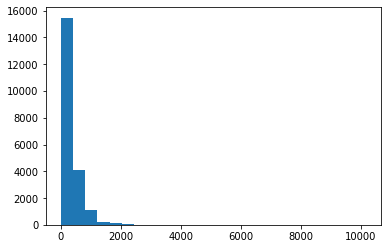

In [ ]:
# Write your code here to visualise the data according to the 'Complaint' character length
length_doc = [len(complaint) for complaint in df.complaint_POS_removed]
plt.hist(length_doc, bins = 25)
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [ ]:
### importing word cloud libraries
from wordcloud import WordCloud

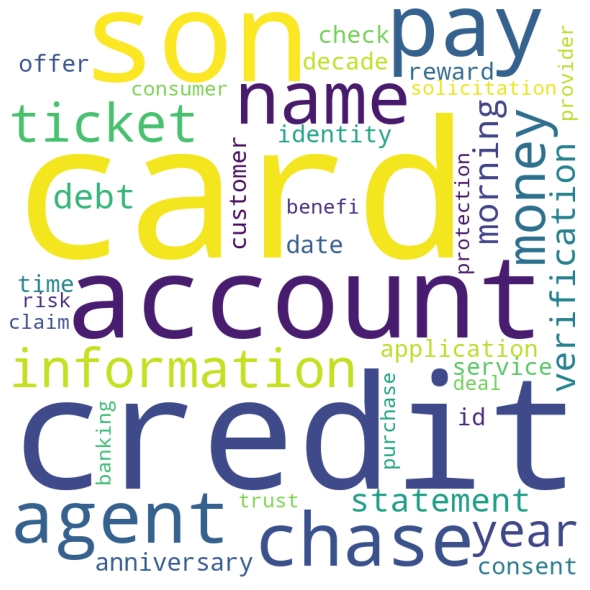

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 8,max_words=40).generate(str(df_clean.complaint_POS_removed))

print(wordcloud)
plt.figure(figsize = (8 ,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

Word cloud done for the 'Complaint_POS_removed' column data and found the 40 max frequency values.

In [ ]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [ ]:
### Function for unigram, bigram, trigram
def get_top_n_gram(corpus, gram=None, n=None):
    vec = CountVectorizer(ngram_range=(gram, gram), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
unigram_words = get_top_n_gram(df_clean.Complaint_clean,1, 30)

In [ ]:
#Print the top 10 words in the unigram frequency
unigram_words[:10]

[('account', 40743),
 ('chase', 33717),
 ('credit', 29895),
 ('card', 29102),
 ('payment', 20149),
 ('time', 15369),
 ('charge', 11973),
 ('money', 11465),
 ('day', 10533),
 ('check', 9955)]

The list of the top 10 unigram frequency data is printed

<function matplotlib.pyplot.show>

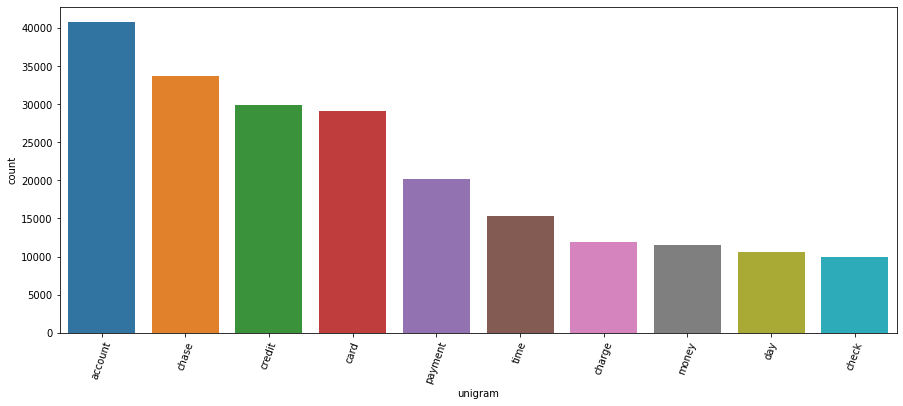

In [ ]:
unigram_df = pd.DataFrame(unigram_words[:10], columns = ['unigram' , 'count'])
plt.figure(figsize = (15 ,6))
sns.barplot(data = unigram_df, x='unigram', y= 'count')
plt.xticks(rotation=70)
plt.show

In [ ]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
bigram_words = get_top_n_gram(df_clean.Complaint_clean,2, 30)

In [ ]:
#Print the top 10 words in the bigram frequency
bigram_words[:10]

[('credit card', 11929),
 ('credit report', 3420),
 ('account account', 2662),
 ('customer service', 2415),
 ('chase credit', 2162),
 ('card account', 1747),
 ('account chase', 1716),
 ('chase account', 1708),
 ('credit score', 1617),
 ('payment payment', 1551)]

The list of the first 10 bigram frequency data is printed

<function matplotlib.pyplot.show>

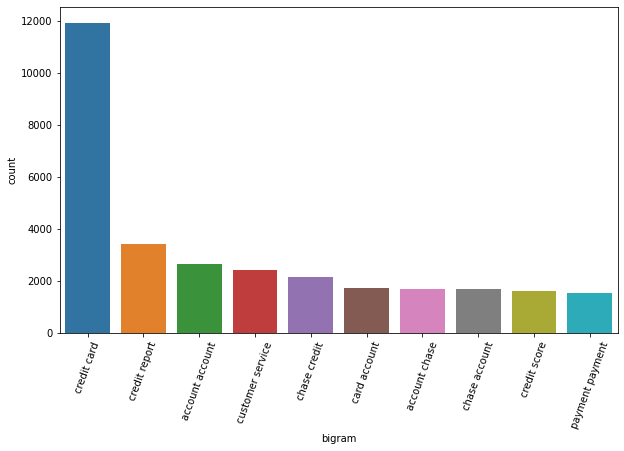

In [ ]:
bigram_df = pd.DataFrame(bigram_words[:10], columns = ['bigram' , 'count'])
plt.figure(figsize = (10 ,6))
sns.barplot(data = bigram_df, x='bigram', y= 'count')
plt.xticks(rotation=70)
plt.show

In [ ]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
trigram_words = get_top_n_gram(df_clean.Complaint_clean,3, 30)

In [ ]:
#Print the top 10 words in the trigram frequency
trigram_words[:10]

[('chase credit card', 1458),
 ('credit card account', 1029),
 ('credit card company', 862),
 ('credit card chase', 640),
 ('credit card credit', 634),
 ('card credit card', 548),
 ('account credit card', 425),
 ('inquiry credit report', 391),
 ('charge credit card', 379),
 ('credit report credit', 361)]

The list of the first 10 trigram frequency data is printed

<function matplotlib.pyplot.show>

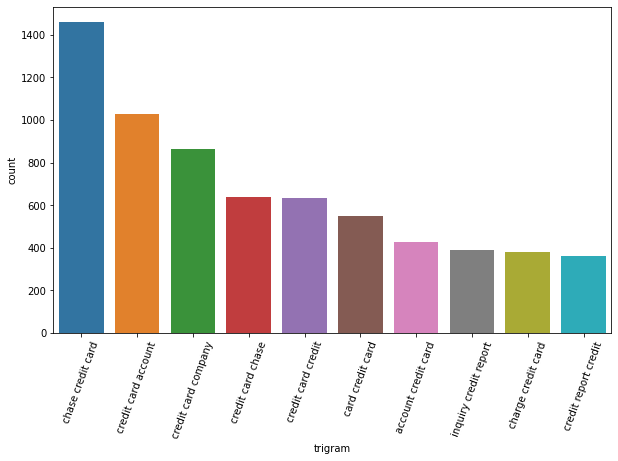

In [ ]:
trigram_df = pd.DataFrame(trigram_words[:10], columns = ['trigram' , 'count'])
plt.figure(figsize = (10 ,6))
sns.barplot(data = trigram_df, x='trigram', y= 'count')
plt.xticks(rotation=70)
plt.show

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [ ]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



As we have seen in the word cloud the value XXXX is occuring in more frequency. It will not add any value to our analysis so we will remove this value from our data

In [ ]:
#All masked texts has been removed
df_clean

,Complaint_details,Lemma_Complaint,complaint_POS_removed,Complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name chase debt verification statement...,morning name chase debt verification statement...
1,i upgraded my xxxx xxxx card in xxxx and w...,upgraded xxxx xxxx card xxxx told agent upgrad...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
2,chase card was reported on xxxx however fr...,chase card reported xxxx however fraudulent ap...,application identity consent service credit id...,application identity consent service credit id...
3,on xxxx while trying to book a xxxx xxxx ...,xxxx trying book xxxx xxxx ticket came across ...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
4,my grand son give me check for i deposi...,grand son give check deposit chase account fun...,son check account money son money pay son time...,son check account money son money pay son time...
...,...,...,...,...
21067,after being a chase card customer for well ove...,chase card customer well decade offered multip...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,card provider claim purchase protection benefi...,card provider claim purchase protection benefi...
21069,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,risk consumer year trust banking deal merchant...,risk consumer year trust banking deal merchant...
21070,i have had flawless credit for yrs ive had ...,flawless credit yr ive chase credit card chase...,credit i credit card chase freedom problem i b...,credit i credit card chase freedom problem i b...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(stop_words='english',max_df = 0.95,min_df = 2)



TF-IDF features with the max-df and min-df is assigned

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean.Complaint_clean)
pd.DataFrame(dtm.toarray(), columns=tfidf.get_feature_names())

,aaaratings,ab,abandonment,abatement,abet,abhorrent,abide,abiding,ability,absence,absolve,absorb,absurdity,abundance,abuse,abusive,acccounts,acceleration,accent,accept,acceptance,access,accessibility,accessing,accessory,accident,accommodation,accomplice,accomplish,accont,accord,accordance,according,accouint,accoun,accound,account,accountability,accountant,accountbalance,...,workplace,workshop,world,worm,worry,worth,worthiness,worthlessness,woudl,wouldbe,wouls,wound,wrap,wreck,wrecking,wrist,writ,write,writeoff,writer,writing,wrong,wrongdoing,wwwchasecom,wwwconsumeraffairscomfinancechase,wwwconsumerfinancegov,xx,ya,yard,yea,year,yelling,yelp,yesterday,yield,yoga,yr,zip,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.126053,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069366,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.061525,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028572,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.144775,0.0,0.0,0.0

Tf-Idf fit transform is performed on the cleaned data.

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [ ]:
### Importing the NMF libraries
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics,random_state=40) #write your code here

We have tried with different combinations of the n_components and finalised our model with the components as 5

In [ ]:
W = nmf_model.fit_transform(dtm)  # Document-topic matrix
H = nmf_model.components_       # Topic-term matrix


Document-topic matrix is stored in W and Topic-Term matrix is stored in H

In [ ]:
W.shape

(21072, 5)

The Document Term matrix is in the shape as above

In [ ]:
H.shape

(5, 5830)

The Topic Term matrix shape is provided above?

In [ ]:
dtm.shape

(21072, 5830)

The dtm should be in the shape of W * H. Which is looking the same.

As we can see in the shape that W*H = dtm.
Its properly taken.

In [ ]:
#Print the Top15 words for each of the topics
wordcol_size = 15
words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, wordcol_size)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(wordcol_size)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:wordcol_size]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,money,fund,bank,deposit,chase,branch,day,number,business,transfer,customer,transaction,time
Topic 2,credit,card,report,inquiry,chase,account,score,company,limit,application,debt,year,balance,information,letter
Topic 3,payment,balance,month,fee,statement,pay,time,date,day,chase,auto,credit,error,car,year
Topic 4,charge,card,transaction,dispute,chase,merchant,fee,claim,fraud,purchase,service,refund,time,email,phone
Topic 5,loan,mortgage,modification,chase,home,year,property,rate,time,document,letter,sale,debt,information,foreclosure


15 topics are chosen

For the 5 topics we have got the list of highest occuring values

In [ ]:
df_doc_topic = pd.DataFrame(np.round(W, 2), 
                            columns=["Topic" + str(i) for i in range(nmf_model.n_components)],
                            index=["Doc" + str(i) for i in range(len(df_clean.Complaint_clean))])
df_doc_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4
Doc0,0.01,0.01,0.01,0.01,0.03
Doc1,0.00,0.01,0.00,0.01,0.01
Doc2,0.00,0.03,0.00,0.00,0.00
Doc3,0.01,0.06,0.00,0.00,0.02
Doc4,0.05,0.00,0.00,0.00,0.00


In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
significant_topic = np.argmax(df_doc_topic.values, axis=1)
significant_topic

array([4, 1, 1, ..., 3, 2, 2])

Best topic is taken based on the the max values of a topic appearing in the document

In [ ]:
df_doc_topic['topic'] = significant_topic

In [ ]:
df_doc_topic

,Topic0,Topic1,Topic2,Topic3,Topic4,topic
Doc0,0.01,0.01,0.01,0.01,0.03,4
Doc1,0.00,0.01,0.00,0.01,0.01,1
Doc2,0.00,0.03,0.00,0.00,0.00,1
Doc3,0.01,0.06,0.00,0.00,0.02,1
Doc4,0.05,0.00,0.00,0.00,0.00,0
...,...,...,...,...,...,...
Doc21067,0.00,0.09,0.02,0.04,0.00,1
Doc21068,0.01,0.01,0.00,0.04,0.01,3
Doc21069,0.01,0.01,0.00,0.02,0.01,3
Doc21070,0.00,0.05,0.09,0.02,0.00,2


The best topic is assigned to each of the record/Document

In [ ]:
df_doc_topic= df_doc_topic.reset_index()
df_doc_topic

,index,Topic0,Topic1,Topic2,Topic3,Topic4,topic
0,Doc0,0.01,0.01,0.01,0.01,0.03,4
1,Doc1,0.00,0.01,0.00,0.01,0.01,1
2,Doc2,0.00,0.03,0.00,0.00,0.00,1
3,Doc3,0.01,0.06,0.00,0.00,0.02,1
4,Doc4,0.05,0.00,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...
21067,Doc21067,0.00,0.09,0.02,0.04,0.00,1
21068,Doc21068,0.01,0.01,0.00,0.04,0.01,3
21069,Doc21069,0.01,0.01,0.00,0.02,0.01,3
21070,Doc21070,0.00,0.05,0.09,0.02,0.00,2


In [ ]:
df_clean.shape

(21072, 4)

In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = df_doc_topic['topic']#write your code to assign topics to each rows.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



The significant topic which is taken for each of the document should be assigned in the df_clean.

In [ ]:
df_clean.head()

,Complaint_details,Lemma_Complaint,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name chase debt verification statement...,morning name chase debt verification statement...,4
1,i upgraded my xxxx xxxx card in xxxx and w...,upgraded xxxx xxxx card xxxx told agent upgrad...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,1
2,chase card was reported on xxxx however fr...,chase card reported xxxx however fraudulent ap...,application identity consent service credit id...,application identity consent service credit id...,1
3,on xxxx while trying to book a xxxx xxxx ...,xxxx trying book xxxx xxxx ticket came across ...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1
4,my grand son give me check for i deposi...,grand son give check deposit chase account fun...,son check account money son money pay son time...,son check account money son money pay son time...,0


In [ ]:
df_clean.shape

(21072, 5)

In [ ]:
#Print the first 5 Complaint for each of the Topics
print_complaint =df_clean.groupby('Topic').head(5)
print_complaint.sort_values('Topic')

,Complaint_details,Lemma_Complaint,complaint_POS_removed,Complaint_clean,Topic
4,my grand son give me check for i deposi...,grand son give check deposit chase account fun...,son check account money son money pay son time...,son check account money son money pay son time...,0
6,with out notice jp morgan chase restricted my ...,notice jp morgan chase restricted account debi...,card branch customer service representative ac...,card branch customer service representative ac...,0
10,mishandling of this account by chase auto and ...,mishandling account chase auto xxxx,,,0
12,i opened an account with chase bank on xxxx an...,opened account chase bank xxxx used code xxxx ...,bonus everything account deposit bonus day xxx...,bonus everything account deposit bonus day de...,0
15,i opened the saving account for the bonus...,opened saving account bonus supposed received ...,account bonus bonus auto transfer checking sav...,account bonus bonus auto transfer checking sav...,0
1,i upgraded my xxxx xxxx card in xxxx and w...,upgraded xxxx xxxx card xxxx told agent upgrad...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,1
2,chase card was reported on xxxx however fr...,chase card reported xxxx however fraudulent ap...,application identity consent service credit id...,application identity consent service credit id...,1
3,on xxxx while trying to book a xxxx xxxx ...,xxxx trying book xxxx xxxx ticket came across ...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1
5,can you please remove inquiry,please remove inquiry,inquiry,inquiry,1
9,i have a chase credit card which is incorrectl...,chase credit card incorrectly reporting data c...,credit card data credit report company issue,credit card data credit report company issue,1


Each topic 5 document is printed and added in the print_complaint dataframe

In [ ]:
df_clean.sort_values('Topic')

,Complaint_details,Lemma_Complaint,complaint_POS_removed,Complaint_clean,Topic
10535,chase bank is advertising a bonus for op...,chase bank advertising bonus opening checking ...,bonus checking account website account coupon ...,bonus checking account website account coupon ...,0
16115,on xxxxxxxx i went to the chase bank at xxxx x...,xxxxxxxx went chase bank xxxx xxxx xxxx xxxx o...,account fee cash receipt show money account mi...,account fee cash receipt show money account mi...,0
16117,we have this account for more than year but ...,account year try use card decline talk agent b...,account year card decline account time reason,account year card decline account time reason,0
6446,chase could you please explain why you closed ...,chase could please explain closed checking sav...,saving account customer account reason reason ...,saving account customer account reason reason ...,0
6445,i have been trying to work with jpmorgan chase...,trying work jpmorgan chase bank locate check w...,work check account occasion item check date nu...,work check account occasion item check date nu...,0
...,...,...,...,...,...
14298,we received a final closing disclosure for our...,received final closing disclosure mortgage jpm...,closing day closing line item state mortgage t...,closing day closing line item state mortgage t...,4
8766,on xxxxxxxx i sent the following email message...,xxxxxxxx sent following email message shown jp...,email message email message email request emai...,email message email message email request emai...,4
17925,our mortgage loan is currently serviced by cha...,mortgage loan currently serviced chase bank en...,mortgage mortgage loan chapter mortgage statem...,mortgage mortgage loan chapter mortgage statem...,4
17870,this is in response to my initial complaint xx...,response initial complaint xxxx regarding mort...,complaint mortgage discrimination chase nothin...,complaint mortgage discrimination chase nothin...,4


In [ ]:
df_clean.shape

(21072, 5)

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0: "Bank account services",
    1: "Theft/Dispute reporting",
    2: "Mortgages/loans",
    3: "Credit card / Prepaid card",
    4: "Others"
   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



After understanding the complaints provided in the training data and the significant topic value displayed, the topic names are assigned.

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

We need to revert back the text to numbers in the topic names, as it will be taken as the y label. it has to be in numbers

In [ ]:
#Create the dictionary again of Topic names and Topics

Topic_names = {
    "Bank account services" : 0,
    "Theft/Dispute reporting" : 1,
    "Mortgages/loans" : 2,
    "Credit card / Prepaid card" : 3,
    "Others" : 4
   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



we have reverted the 'Topic Names' to numbers since the 'Y' column needs to be in numbers

In [ ]:
df_clean.shape

(21072, 5)

In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[['Complaint_details','Topic']]

Only the required X and Y is taken. The X is Complaint_details and the Y is label/Topic for each of the complaint assigned

In [ ]:
training_data.shape

(21072, 2)

In [ ]:
training_data

,Complaint_details,Topic
0,good morning my name is xxxx xxxx and i apprec...,4
1,i upgraded my xxxx xxxx card in xxxx and w...,1
2,chase card was reported on xxxx however fr...,1
3,on xxxx while trying to book a xxxx xxxx ...,1
4,my grand son give me check for i deposi...,0
...,...,...
21067,after being a chase card customer for well ove...,1
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,3
21069,i am not familiar with xxxx pay and did not un...,3
21070,i have had flawless credit for yrs ive had ...,2


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = training_data.Complaint_details
y = training_data.Topic

splitting test and train dataset. Since we have only 20k records, we will have 80-20 % of record in Train and Test dataset

In [ ]:
### Splitting the test train data seperately
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
import pickle
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
#Write your code to get the Vector count
vectorizer = CountVectorizer()
  
vector = vectorizer.fit_transform(X_train)

testvector = vectorizer.transform(X_test)

In [ ]:
#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(vector)
X_tfidf = tfidf_transformer.transform(vector)
X_testtfidf = tfidf_transformer.transform(testvector)

In [ ]:
#SAVE TF-IDF
pickle.dump(X_tfidf, open("tfidf.pkl","wb"))


In [ ]:
X_train = X_tfidf
X_test = X_testtfidf

Transformed both the Train and Test data.

You have to try atleast 2 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics
## We have bulit for the Logistic regression, Decision Tree and RandomForest

In [ ]:
### Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
## Scikit-learn features various classification, regression and clustering algorithms
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import average_precision_score, confusion_matrix, accuracy_score, classification_report, plot_confusion_matrix


Building the Logistic Regression model for the multiclass data

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=0)
model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = model.predict(X_test)
y_pred

array([0, 3, 4, ..., 1, 1, 4])

In [ ]:
# Let's measure the accuracy of this model's prediction
accuracy_score(y_test, y_pred)

0.900355871886121

In [ ]:
LRAccuracy = accuracy_score(y_test, y_pred)

The Accuracy score for the Logistic regression is 90%

In [ ]:
# And some other metrics 

print(classification_report(y_test, y_pred, digits=2))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1140
           1       0.90      0.92      0.91      1075
           2       0.95      0.85      0.90       484
           3       0.88      0.88      0.88       865
           4       0.92      0.91      0.92       651

    accuracy                           0.90      4215
   macro avg       0.91      0.90      0.90      4215
weighted avg       0.90      0.90      0.90      4215



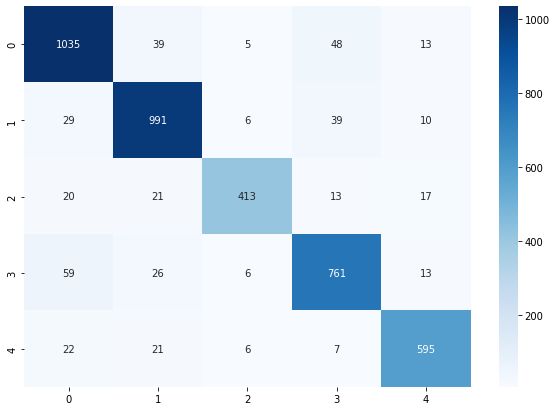

In [ ]:
# Display confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
df_conf_mat = pd.DataFrame(conf_mat)
plt.figure(figsize = (10,7))
sns.heatmap(df_conf_mat, annot=True,cmap='Blues', fmt='g')

Building Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt_base = DecisionTreeClassifier(random_state=42, max_depth=4)

In [ ]:
dt_base.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
y_train_pred = dt_base.predict(X_train)
y_test_pred = dt_base.predict(X_test)

In [ ]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.73      0.62      0.67      1140
           1       0.74      0.79      0.77      1075
           2       0.81      0.62      0.70       484
           3       0.43      0.68      0.53       865
           4       0.87      0.52      0.65       651

    accuracy                           0.66      4215
   macro avg       0.72      0.65      0.66      4215
weighted avg       0.70      0.66      0.67      4215



Without hyperparameter tuning only with the max_depth as 4 is giving the Accuracy as 66%. Lets perform hyperparameter tuning

Building the Decision Tree Classifier with hyper parameter

In [ ]:
dt = DecisionTreeClassifier(random_state=42)

In [ ]:
params = {
    "max_depth": [10,20,50,70],
    "min_samples_leaf": [10,20,50],
    "min_samples_split" : [2,5,10]
}

In [ ]:
dtgrid_search = GridSearchCV(estimator=dt,
                           param_grid=params,
                           cv=5,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [ ]:
%%time
dtgrid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  9.8min finished


CPU times: user 10.5 s, sys: 523 ms, total: 11 s
Wall time: 9min 54s


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [10, 20, 50, 70],
                         '

In [ ]:
dtgrid_search.best_score_

0.7897011809259988

In [ ]:
dt_y_test_pred = dtgrid_search.predict(X_test)

In [ ]:
print(classification_report(y_test, dt_y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1140
           1       0.81      0.84      0.82      1075
           2       0.79      0.77      0.78       484
           3       0.67      0.73      0.70       865
           4       0.86      0.78      0.82       651

    accuracy                           0.78      4215
   macro avg       0.79      0.78      0.78      4215
weighted avg       0.79      0.78      0.78      4215



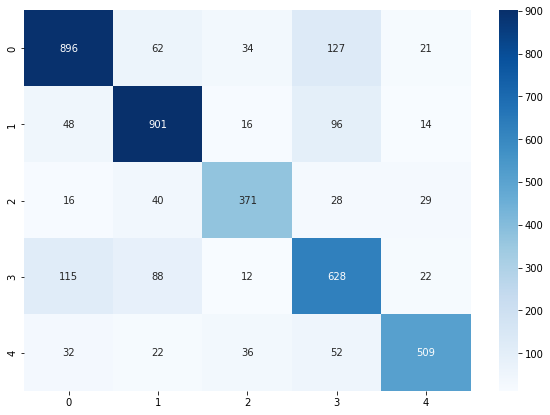

In [ ]:
# Display confusion matrix
conf_mat = confusion_matrix(y_test, dt_y_test_pred)
df_conf_mat = pd.DataFrame(conf_mat)
plt.figure(figsize = (10,7))
sns.heatmap(df_conf_mat, annot=True,cmap='Blues', fmt='g')

In [ ]:
dtAccuracy = dtgrid_search.best_score_

The Best score in the Decision Tree is 78%

In [ ]:
dt_best = dtgrid_search.best_estimator_
dt_best

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
dt_best.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
dt_y_train_pred = dt_best.predict(X_train)
dt_y_test_pred = dt_best.predict(X_test)

In [ ]:
print(classification_report(y_test, dt_y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1140
           1       0.81      0.84      0.82      1075
           2       0.79      0.77      0.78       484
           3       0.67      0.73      0.70       865
           4       0.86      0.78      0.82       651

    accuracy                           0.78      4215
   macro avg       0.79      0.78      0.78      4215
weighted avg       0.79      0.78      0.78      4215



In [ ]:
dtAccuracy = accuracy_score(y_test, dt_y_test_pred)
dtAccuracy

0.7841043890865955

Building the Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [ ]:
params = {
    'max_depth': [50,60,70],
    'min_samples_leaf': [2,5,10],
    'n_estimators': [50, 75,100],
    'min_samples_split' : [2,5]
}

In [ ]:
rfgrid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 5,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [ ]:
%%time
rfgrid_search.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 34.0min finished


CPU times: user 36.3 s, sys: 896 ms, total: 37.2 s
Wall time: 34min 16s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=42,
                                    

In [ ]:
rfgrid_search.best_score_

0.7956926235320241

In [ ]:
rfAccuracy = rfgrid_search.best_score_
rfAccuracy

0.7956926235320241

The best score is 79.56%

In [ ]:
rf_best = rfgrid_search.best_estimator_
rf_best

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=70, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
rf_y_test_pred = rf_best.predict(X_test)

In [ ]:
print(classification_report(y_test, rf_y_test_pred))

              precision    recall  f1-score   support

           0       0.78      0.88      0.82      1140
           1       0.77      0.88      0.82      1075
           2       0.93      0.48      0.63       484
           3       0.82      0.77      0.79       865
           4       0.86      0.85      0.86       651

    accuracy                           0.81      4215
   macro avg       0.83      0.77      0.79      4215
weighted avg       0.82      0.81      0.80      4215



Based on the best estimator for the random forest, the Accuracy is 81%


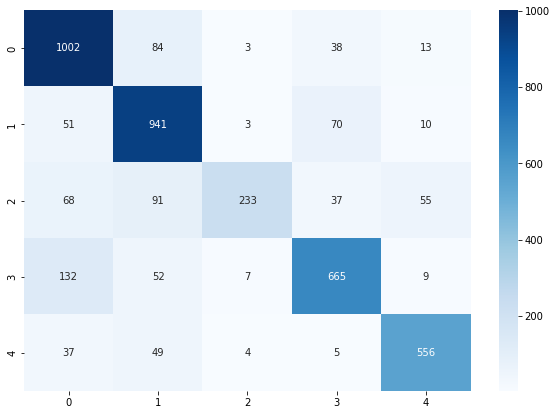

In [ ]:
# Display confusion matrix
conf_mat = confusion_matrix(y_test, rf_y_test_pred)
df_conf_mat = pd.DataFrame(conf_mat)
plt.figure(figsize = (10,7))
sns.heatmap(df_conf_mat, annot=True,cmap='Blues', fmt='g')

In [ ]:
rfAccuracy = accuracy_score(y_test, rf_y_test_pred)
rfAccuracy

0.8059311981020166

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
clf = MultinomialNB().fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred

array([0, 3, 4, ..., 1, 1, 4])

In [ ]:
# Let's measure the accuracy of this model's prediction
accuracy_score(y_test, y_pred)

0.672835112692764

In [ ]:
data = {'Model' : ['Logistic Regression','Decision Tree','Random Forest'],
        'Accuracy' : [LRAccuracy,dtAccuracy,rfAccuracy]}
resultdf = pd.DataFrame(data)

In [ ]:
resultdf

,Model,Accuracy
0,Logistic Regression,0.900356
1,Decision Tree,0.784104
2,Random Forest,0.805931


We can see that Logistic Regression have better accuracy than the other models. Hence using it for verifying the test message.

In [ ]:
Topic_names

{'Bank account services': 0,
 'Credit card / Prepaid card': 3,
 'Mortgages/loans': 2,
 'Others': 4,
 'Theft/Dispute reporting': 1}

These are the current topics, We will change the key value change

In [ ]:
nTopic_names = {
    0: "Bank account services",
    1: "Theft/Dispute reporting",
    2: "Mortgages/loans",
    3: "Credit card / Prepaid card",
    4: "Others"
   }

Using Logistic Regression model for predicting the text provided randomly.

In [ ]:
texts = ['I have applied for the new account opening. Account opening application is not getting progressed']
vectexts = vectorizer.transform(texts)
text_features = tfidf_transformer.transform(vectexts)
predictions = model.predict(text_features)
print(predictions[0])
print(texts)
print(nTopic_names[predictions[0]])

0
['I have applied for the new account opening. Account opening application is not getting progressed']
Bank account services


In [ ]:
texts = ['The check is not getting accepted. The money is not credited to the account']
vectexts = vectorizer.transform(texts)
text_features = tfidf_transformer.transform(vectexts)
predictions = model.predict(text_features)
print(predictions[0])
print(texts)
print(nTopic_names[predictions[0]])

0
['The check is not getting accepted. The money is not credited to the account']
Bank account services


In [ ]:
texts = ['i have received the information verification mail and i have filled out all the docs later found that i am the victim of identity theft. I have raised issue not solved']
vectexts = vectorizer.transform(texts)
text_features = tfidf_transformer.transform(vectexts)
predictions = model.predict(text_features)
print(predictions[0])
print(texts)
print(nTopic_names[predictions[0]])

1
['i have received the information verification mail and i have filled out all the docs later found that i am the victim of identity theft. I have raised issue not solved']
Theft/Dispute reporting


In [ ]:
texts = ['I have made payment for the loan account however it is not reflecting']
vectexts = vectorizer.transform(texts)
text_features = tfidf_transformer.transform(vectexts)
predictions = model.predict(text_features)
print(predictions[0])
print(texts)
print(nTopic_names[predictions[0]])

2
['I have made payment for the loan account however it is not reflecting']
Mortgages/loans


I have tried to provide the text by myself other than the test records. 
Provided few different data for different classifier.
It is working properly.